# Spotting SAT Test Unfairness - Analysing New York City High School Data

# Table of Content
1. Introduction
2. Reading in the Data
3. Exploring the SAT Data
4. Exploring the Remaining Data
5. Reading in the Survey Data
6. Cleaning Up the Surveys
7. Inserting dbn Fields 
8. Combining the SAT Scores
9. Parsing Geographic Coordinates for Schools
10. Exctracting the Latitude
11. Exctracting the Longitude 
12. Combining the Data 
13. Computing Average Class Sizes
14. Condensing the Demographics Data Set
15. Condensing the Graduation Data Set
16. Converting AP Test Scores 
17. Performing Left Joins
18. Performing Inner Joins
19. Filling in Missing Values 
20. Adding a School District Column for Mapping
21. Analysing and Visualising the Data 
22. Finding Correlations with the r Value
23. Plotting Enrollment With the Plot() Accessor
24. Plotting Language Learning Percentage
25. Calculating District-Level Statistics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

/var/folders/qs/fdrj_gks73v_3fn5zbpyl2000000gn/T/ipykernel_65207/1390799068.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Introduction

The purpose of this project is to explore the relationship between SAT scores and demographic factors in New York City (NYC) public high schools. The SAT test (i.e., Scholastic Aptitute Test), is a test for high school seniors in the U.S., who take it every year. It consists of three sections, worth `800` points each. This test is used to determine which students to admit to high school. Usually, high average SAT scores are indicative of a good school. Since New York City has a very diverse population, comparing multiple demographics such as race, income, and gender is a good way to check whether the SAT test is fair or not.

We'll perform our analysis by combining multiple datasets into a single, clean pandas dataframe. We will then start analysing the data by creating correlations. We eventually found out that some demographics are not very strong indicators of high SAT scores (e.g., gender), whereas some other indicators suggest high SAT scores (e.g., safety scores by students and teachers). A more detailed description of the conclusions can be found in the last section of the project.

## Reading in the Data

In [2]:
# Create a list of file names 
data_files = ["ap_2010_results.csv",
    "classes_sizes.csv",
    "schools_demographics.csv",
    "graduation_outcomes.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

# Create dictionary of dataframes
dfs_dict = {} 

# Read and store dataframes into dictionary 
for file in data_files:
    df = pd.read_csv(f"~/Desktop/repos/nyc_high_school/{file}")
    dfs_dict[file.replace(".csv", "")] = df  

## Exploring the SAT Data

The dataset we are more interested in is the SAT dataset as it contains the SAT scores for each high school in NYC. We will then correlate SAT information with information from other datasets.

In [3]:
# Lower columns
def lowercase_columns(df):
    df.columns = map(str.lower, df.columns)
    return df

for key, df in dfs_dict.items():
    dfs_dict[key] = lowercase_columns(df)

In [4]:
# Explore SAT results
dfs_dict["sat_results"].head()

,dbn,school name,num of sat test takers,sat critical reading avg. score,sat math avg. score,sat writing avg. score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


Based on this output, we can make a couple of observations: 
    
- The `dbn` is a unique ID for each school.
- We can see from the first few rows of names that we only have data about high schools.
- We only have a single row for each high school, so each `dbn` is unique in the SAT data.
- We will want to combine the three columns with SAT scores -- `SAT Critical Reading Avg. Score, SAT Math Avg. Score, and SAT Writing Avg. Score` -- into a single column to make the data easier to analyse.

Now, let's explore the data in a different dataset to see how we can combine them.

## Exploring the Remaining Data

In [5]:
# Display dataframes' heads 
dfs_dict["ap_2010_results"].head()

,dbn,schoolname,ap test takers,total exams taken,number of exams with scores 3 4 or 5
0,01M448,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,10.0
1,01M450,EAST SIDE COMMUNITY HS,19.0,21.0,NaN
2,01M515,LOWER EASTSIDE PREP,24.0,26.0,24.0
3,01M539,"NEW EXPLORATIONS SCI,TECH,MATH",255.0,377.0,191.0
4,02M296,High School of Hospitality Management,NaN,NaN,NaN


In [6]:
dfs_dict["classes_sizes"].head()

,csd,borough,school code,school name,grade,program type,core subject (ms core and 9-12 only),core course (ms core and 9-12 only),service category(k-9* only),number of students / seats filled,number of sections,average class size,size of smallest class,size of largest class,data source,schoolwide pupil-teacher ratio
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN


In [7]:
dfs_dict["schools_demographics"].head()

,dbn,name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


In [8]:
dfs_dict["graduation_outcomes"].head()

,demographic,dbn,school name,cohort,total cohort,total grads - n,total grads - % of cohort,total regents - n,total regents - % of cohort,total regents - % of grads,...,regents w/o advanced - n,regents w/o advanced - % of cohort,regents w/o advanced - % of grads,local - n,local - % of cohort,local - % of grads,still enrolled - n,still enrolled - % of cohort,dropped out - n,dropped out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,NaN,s,NaN,NaN,...,s,NaN,NaN,s,NaN,NaN,s,NaN,s,NaN
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3,17,30.9,45.9,...,17,30.9,45.9,20,36.4,54.1,15,27.3,3,5.5
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2,27,42.2,62.8,...,27,42.2,62.8,16,25.0,37.2,9,14.1,9,14.1
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1,36,46.2,83.7,...,36,46.2,83.7,7,9.0,16.3,16,20.5,11,14.1
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4,37,47.4,84.1,...,37,47.4,84.1,7,9.0,15.9,15,19.2,11,14.1


In [9]:
dfs_dict["hs_directory"].head()

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,location 1
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67..."
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9,12,NaN,NaN,...,Then to New York City residents who attend an ...,Then to Bronx students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"1110 Boston Road\nBronx, NY 10456\n(40.8276026..."
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6,12,NaN,NaN,...,Then to Bronx students or residents who attend...,Then to New York City residents who attend an ...,Then to Bronx students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"1501 Jerome Avenue\nBronx, NY 10452\n(40.84241..."
3,02M280,Manhattan Early College School for Advertising,Manhattan,M520,718-935-3477,NaN,9,10,9,14.0,...,Then to New York City residents who attend an ...,Then to Manhattan students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"411 Pearl Street\nNew York, NY 10038\n(40.7106..."
4,28Q680,Queens Gateway to Health Sciences Secondary Sc...,Queens,Q695,718-969-3155,718-969-3552,6,12,NaN,NaN,...,Then to Districts 28 and 29 students or residents,Then to Queens students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"160-20 Goethals Avenue\nJamaica, NY 11432\n(40..."


In [10]:
dfs_dict["sat_results"].head()

,dbn,school name,num of sat test takers,sat critical reading avg. score,sat math avg. score,sat writing avg. score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


Based on the first few rows of each dataset, we can make some observations:
- Each dataset has either a `dbn` column or the information we need to create one. This means that we can use the `dbn` column to combine the datasets. We will pinpoint matching rows from different datasets. We will do this by looking for identical `dbn`s. Then, we will group all their columns together in a single dataset.
- `Location 1` looks like an interesting field for mapping. This field contains coordinates inside a larger string.
- Some datasets have many rows for each school (since the rows have duplicate `dbn` values). So we will have to do some preprocessing to make sure that each `dbn` is unique within each dataset. If we don't, we will run into problems when we combine the datasets. This will happen because we could be merging two rows in one data set with one row in another dataset.

## Reading in the Survey Data

In [11]:
# Read in surveys
all_survey_df = pd.read_excel('survey_all.xlsx', header=2)
d75_survey_df = pd.read_excel('survey_d75.xlsx', header=2)

In [12]:
# Combine surveys and create a copy 
surveys_df = pd.concat([all_survey_df, d75_survey_df], axis=0)
surveys_df = surveys_df.copy()
surveys_df.head()

,dbn,schoolname,rr_s,rr_t,rr_p,N_s,N_t,N_p,nr_s,nr_t,...,s_q14_2,s_q14_3,s_q14_4,s_q14_5,s_q14_6,s_q14_7,s_q14_8,s_q14_9,s_q14_10,s_q14_11
0,01M015,P.S. 015 Roberto Clemente,NaN,88,60,NaN,22.0,90.0,0,25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01M019,P.S. 019 Asher Levy,NaN,100,60,NaN,34.0,161.0,0,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01M020,P.S. 020 Anna Silver,NaN,88,73,NaN,42.0,367.0,0,48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01M034,P.S. 034 Franklin D. Roosevelt,89.0,73,50,145.0,29.0,151.0,163,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M063,P.S. 063 William McKinley,NaN,100,60,NaN,23.0,90.0,0,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here's what we can immediately see from the data:
    
- There are over `2000` columns, all which we won't need. We will have to filter the data to remove the unnecessary ones so that we can print the dataframe and find correlations within it more easily.

## Cleaning Up the Surveys

We will use the [data dictionary](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) to assess which columns to remove and which ones to keep.

In [13]:
# Create a list of relevant columns
survey_fields = [
    "dbn", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

# Filter surveys
surveys_df = surveys_df.loc[:,survey_fields]

# Assign survey to the dictionary
dfs_dict["surveys"] = surveys_df

# Explore the surveys
surveys_df.head()

,dbn,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,...,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M015,NaN,88,60,NaN,22.0,90.0,8.5,7.6,7.5,...,7.6,7.9,NaN,NaN,NaN,NaN,8.0,7.7,7.5,7.9
1,01M019,NaN,100,60,NaN,34.0,161.0,8.4,7.6,7.6,...,8.9,9.1,NaN,NaN,NaN,NaN,8.5,8.1,8.2,8.4
2,01M020,NaN,88,73,NaN,42.0,367.0,8.9,8.3,8.3,...,6.8,7.5,NaN,NaN,NaN,NaN,8.2,7.3,7.5,8.0
3,01M034,89.0,73,50,145.0,29.0,151.0,8.8,8.2,8.0,...,6.8,7.8,6.2,5.9,6.5,7.4,7.3,6.7,7.1,7.9
4,01M063,NaN,100,60,NaN,23.0,90.0,8.7,7.9,8.1,...,7.8,8.1,NaN,NaN,NaN,NaN,8.5,7.6,7.9,8.0


## Inserting dbn Fields 

When we explored all of the datasets, we noticed that `classes_sizes` does not have a `dbn` column.

In [14]:
# Display classes size dataframe
dfs_dict['classes_sizes'].head()

,csd,borough,school code,school name,grade,program type,core subject (ms core and 9-12 only),core course (ms core and 9-12 only),service category(k-9* only),number of students / seats filled,number of sections,average class size,size of smallest class,size of largest class,data source,schoolwide pupil-teacher ratio
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN


Here below are the first few columns of `sat_results`, which have a `dbn` column.

In [15]:
# Explore SAT results data
dfs_dict['sat_results'].head()

,dbn,school name,num of sat test takers,sat critical reading avg. score,sat math avg. score,sat writing avg. score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


However, as shown above, the `dbn` column in the `sat_results` data is just a combination of the `CSD` and `SCHOOL CODE` column in the `classes_sizes` data. The only difference is that the `dbn` is padded, so that `CSD` always consists of two digits. This means that if we add a leading `0` to the `CSD` that have only one digit, we will be able to combine the two columns and generate a `dbn` value for the `classes_sizes` data too. 

In [16]:
# Create a function that pads columns
def pad_csd(num): 
    return f"{num:02}"

# Apply the function
dfs_dict['classes_sizes']['padded_csd'] = dfs_dict['classes_sizes']['csd'].apply(pad_csd) 

# Merge padded_csd and `dfs_dict['classes_sizes']`
dfs_dict['classes_sizes']['dbn'] = dfs_dict['classes_sizes']['padded_csd'] + dfs_dict['classes_sizes']['school code']
dfs_dict['classes_sizes'] = dfs_dict['classes_sizes'].drop(columns=['csd', 'padded_csd', 'borough', 'school code'], axis=1)
dfs_dict['classes_sizes'].head()

,school name,grade,program type,core subject (ms core and 9-12 only),core course (ms core and 9-12 only),service category(k-9* only),number of students / seats filled,number of sections,average class size,size of smallest class,size of largest class,data source,schoolwide pupil-teacher ratio,dbn
0,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01M015
1,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01M015
2,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01M015
3,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01M015
4,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01M015


## Combining the SAT Scores

In [17]:
# Create a list with all SAT scores columns
columns = ['sat math avg. score', 'sat critical reading avg. score', 'sat writing avg. score']

# Convert column values from string to numeric to add them together 
for column in columns:
    dfs_dict['sat_results'][column] = pd.to_numeric(dfs_dict['sat_results'][column], errors = "coerce") # Coerce treats invalid strings as missing values

# Create a combined SAT scores column 
dfs_dict['sat_results']['sat_score'] = dfs_dict['sat_results'][columns[0]] + dfs_dict['sat_results'][columns[1]] + dfs_dict['sat_results'][columns[2]]

# Display combined SAT scores 
dfs_dict['sat_results']['sat_score']

0      1122.0
1      1172.0
2      1149.0
3      1174.0
4      1207.0
        ...  
473       NaN
474       NaN
475       NaN
476    1322.0
477    1097.0
Name: sat_score, Length: 478, dtype: float64

## Parsing Geographic Coordinates for Schools

In [18]:
# Display latitude and longitude coordinates to map schools  
dfs_dict['hs_directory']['location 1'][0]

'883 Classon Avenue\nBrooklyn, NY 11225\n(40.67029890700047, -73.96164787599963)'

### Exctracting the Latitude

In [19]:
# Create a function to extract latitudes
def find_latitude(string): 
    coords = re.findall("\(.+\)", string) 
    latitude = coords[0].split(",")[0].replace("(", "") 
    return latitude 

# Apply function and create new latitude column
dfs_dict['hs_directory']['latitude'] = dfs_dict['hs_directory']['location 1'].apply(find_latitude)

# Displaying the first few rows to verify results 
dfs_dict['hs_directory'].head()

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,location 1,latitude
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",40.67029890700047
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9,12,NaN,NaN,...,Then to Bronx students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"1110 Boston Road\nBronx, NY 10456\n(40.8276026...",40.8276026690005
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6,12,NaN,NaN,...,Then to New York City residents who attend an ...,Then to Bronx students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...",40.842414068000494
3,02M280,Manhattan Early College School for Advertising,Manhattan,M520,718-935-3477,NaN,9,10,9,14.0,...,Then to Manhattan students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"411 Pearl Street\nNew York, NY 10038\n(40.7106...",40.71067947100045
4,28Q680,Queens Gateway to Health Sciences Secondary Sc...,Queens,Q695,718-969-3155,718-969-3552,6,12,NaN,NaN,...,Then to Queens students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"160-20 Goethals Avenue\nJamaica, NY 11432\n(40...",40.718810094000446


### Extracting the Longitude

Now we will do the same for the longitude.

In [20]:
# Create a function to extract the longitude 
def find_longitude(string):
    coords = re.findall("\(.+\)", string) 
    longitude = coords[0].split(",")[1].replace(")", "").strip() 
    return longitude

# Apply the function 
dfs_dict['hs_directory']['longitude'] = dfs_dict['hs_directory']['location 1'].apply(find_longitude)

# Converting `lat` and `lon` columns to numbers
dfs_dict['hs_directory']['latitude'] = pd.to_numeric(dfs_dict['hs_directory']['latitude'], errors="coerce")
dfs_dict['hs_directory']['longitude'] = pd.to_numeric(dfs_dict['hs_directory']['longitude'], errors="coerce")

# Exploring the data
dfs_dict['hs_directory'].head()

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,location 1,latitude,longitude
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",40.670299,-73.961648
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9,12,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"1110 Boston Road\nBronx, NY 10456\n(40.8276026...",40.827603,-73.904475
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6,12,NaN,NaN,...,Then to Bronx students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...",40.842414,-73.916162
3,02M280,Manhattan Early College School for Advertising,Manhattan,M520,718-935-3477,NaN,9,10,9,14.0,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"411 Pearl Street\nNew York, NY 10038\n(40.7106...",40.710679,-74.000807
4,28Q680,Queens Gateway to Health Sciences Secondary Sc...,Queens,Q695,718-969-3155,718-969-3552,6,12,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"160-20 Goethals Avenue\nJamaica, NY 11432\n(40...",40.718810,-73.806500


## Combining the Data 

So far, we found that we can combine the datasets using the `dbn` column. However, before combining them, we need to condense some of the datasets in preparation for the merge. For instance, `classes_sizes` has duplicate `dbn` values, which can cause issues if we don't condense them before the merge. A single row in `sat_results` could match many rows in `classes_sizes`, and we don't know which one we should combine with the single matching entries. Let's condense `classes_sizes`, `graduation`, and `demographics` so that each `dbn` in each dataset will be unique. 

In [21]:
# Explore `classes_sizes` 
dfs_dict['classes_sizes'].head()

,school name,grade,program type,core subject (ms core and 9-12 only),core course (ms core and 9-12 only),service category(k-9* only),number of students / seats filled,number of sections,average class size,size of smallest class,size of largest class,data source,schoolwide pupil-teacher ratio,dbn
0,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01M015
1,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01M015
2,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01M015
3,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01M015
4,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01M015


`dbn` appears more than once because the first few rows all pertain to the same school. Moreover, each school has multiple values for `GRADE`, `PROGRAM TYPE`, `CORE SUBJECT (MS CORE and 9-12 ONLY)`, and `CORE COURSE (MS CORE and 9-12 ONLY)`. 

In [22]:
# Explore grade column
dfs_dict['classes_sizes']['grade '].unique()

array(['0K', '01', '02', '03', '04', '05', '0K-09', nan, '06', '07', '08',
       'MS Core', '09-12', '09'], dtype=object)

In [23]:
# Explore program type column 
dfs_dict['classes_sizes']['program type'].unique()

array(['GEN ED', 'CTT', 'SPEC ED', nan, 'G&T'], dtype=object)

In [24]:
# Finding the most common program 
dfs_dict['classes_sizes']["program type"].value_counts()

program type
GEN ED     14545
CTT         7460
SPEC ED     3653
G&T          469
Name: count, dtype: int64

In [25]:
# Assign dataframe to a variable
classes_sizes = dfs_dict['classes_sizes']

# Pick high schools rows only
classes_sizes = classes_sizes[classes_sizes['grade '] == '09-12']

# Select largest category of programs in each school
classes_sizes = classes_sizes[classes_sizes['program type'] == 'GEN ED']

classes_sizes.head()

,school name,grade,program type,core subject (ms core and 9-12 only),core course (ms core and 9-12 only),service category(k-9* only),number of students / seats filled,number of sections,average class size,size of smallest class,size of largest class,data source,schoolwide pupil-teacher ratio,dbn
225,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01M292
226,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01M292
227,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01M292
228,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01M292
229,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01M292


### Computing Average Class Sizes

As shown above, `dbn` in `classes_sizes` is still not completely unique. This is because of the values in the `CORE SUBJECT (MS CORE and 9-12 ONLY)` and `CORE COURSE (MS CORE and 9-12 ONLY)` columns. The two columns do not include all subjects and courses, however we want to include every single class. 

In [26]:
# Take average across all classes of each school to get a unique 'dbn' value 
classes_sizes = classes_sizes.groupby('dbn').mean(numeric_only=True).reset_index() 

# Assign result back to classes_sizes
dfs_dict['classes_sizes'] = classes_sizes

# Display classes sizes 
dfs_dict['classes_sizes'].head()

,dbn,number of students / seats filled,number of sections,average class size,size of smallest class,size of largest class,schoolwide pupil-teacher ratio
0,01M292,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,57.6000,2.733333,21.200000,19.40,22.866667,NaN


### Condensing the Demographics Data Set

In [27]:
# Look at the data
dfs_dict['schools_demographics'].head()

,dbn,name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


In [28]:
dfs_dict['schools_demographics']["schoolyear"].value_counts()

schoolyear
20112012    1509
20102011    1498
20092010    1475
20082009    1441
20072008    1410
20062007    1386
20052006    1356
Name: count, dtype: int64

In [29]:
# Select rows where `schoolyear` is `20112012` so that we can have unique `dbn`s
dfs_dict['schools_demographics'] = dfs_dict['schools_demographics'][dfs_dict['schools_demographics']['schoolyear'] == 20112012] 
dfs_dict['schools_demographics'].head()

,dbn,name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


### Condensing the Graduation Dataframe

In [30]:
# Display graduation dataframe
dfs_dict['graduation_outcomes'].head()

,demographic,dbn,school name,cohort,total cohort,total grads - n,total grads - % of cohort,total regents - n,total regents - % of cohort,total regents - % of grads,...,regents w/o advanced - n,regents w/o advanced - % of cohort,regents w/o advanced - % of grads,local - n,local - % of cohort,local - % of grads,still enrolled - n,still enrolled - % of cohort,dropped out - n,dropped out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,NaN,s,NaN,NaN,...,s,NaN,NaN,s,NaN,NaN,s,NaN,s,NaN
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3,17,30.9,45.9,...,17,30.9,45.9,20,36.4,54.1,15,27.3,3,5.5
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2,27,42.2,62.8,...,27,42.2,62.8,16,25.0,37.2,9,14.1,9,14.1
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1,36,46.2,83.7,...,36,46.2,83.7,7,9.0,16.3,16,20.5,11,14.1
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4,37,47.4,84.1,...,37,47.4,84.1,7,9.0,15.9,15,19.2,11,14.1


In [31]:
dfs_dict['graduation_outcomes']['cohort'].value_counts()

cohort
2006 Aug    4131
2006        4130
2005        3963
2004        3708
2003        3432
2002        3095
2001        2637
Name: count, dtype: int64

In [32]:
# Select most recent cohort
dfs_dict['graduation_outcomes'] = dfs_dict['graduation_outcomes'][dfs_dict['graduation_outcomes']['cohort'] == '2006'] 

# Select total cohort from demographics to get unique `dbn`s
dfs_dict['graduation_outcomes'] = dfs_dict['graduation_outcomes'][dfs_dict['graduation_outcomes']['demographic'] == 'Total Cohort'] 

dfs_dict['graduation_outcomes'].head()

,demographic,dbn,school name,cohort,total cohort,total grads - n,total grads - % of cohort,total regents - n,total regents - % of cohort,total regents - % of grads,...,regents w/o advanced - n,regents w/o advanced - % of cohort,regents w/o advanced - % of grads,local - n,local - % of cohort,local - % of grads,still enrolled - n,still enrolled - % of cohort,dropped out - n,dropped out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1,36,46.2,83.7,...,36,46.2,83.7,7,9.0,16.3,16,20.5,11,14.1
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7,42,33.9,79.2,...,34,27.4,64.2,11,8.9,20.8,46,37.1,20,16.1
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8,67,74.4,95.7,...,67,74.4,95.7,3,3.3,4.3,15,16.7,5,5.6
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56.0,40,47.6,85.1,...,23,27.4,48.9,7,8.3,14.9,25,29.8,5,6.0
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4,91,47.2,86.7,...,22,11.4,21.0,14,7.3,13.3,53,27.5,35,18.1


## Converting AP Test Scores 

The last task before combining all datasets is to convert the Advanced Placement (AP) test scores from string to numeric values. AP tests are exams that students take before applying to college, and they have a `1` to `5` scale and `3` or higher as a passing score. It is rarer to find AP exams in schools that luck funding or academic rigour. It would be interesting to discover if there is a correlation between AP exam scores and SAT scores. 

In [33]:
# Create a list with columns to convert
cols_to_convert = ['ap test takers ', 'total exams taken', 'number of exams with scores 3 4 or 5']

# Convert strings to numeric 
for col in cols_to_convert: 
    dfs_dict['ap_2010_results'][col] = pd.to_numeric(dfs_dict['ap_2010_results'][col], errors = "coerce") 

# Explore the data type after the changes 
dfs_dict['ap_2010_results'].dtypes

dbn                                      object
schoolname                               object
ap test takers                          float64
total exams taken                       float64
number of exams with scores 3 4 or 5    float64
dtype: object

## Performing Left Joins

In [34]:
set(dfs_dict["sat_results"].columns).intersection(dfs_dict['ap_2010_results'].columns)

{'dbn'}

In [35]:
set(dfs_dict["sat_results"].columns).intersection(dfs_dict['graduation_outcomes'].columns)

{'dbn', 'school name'}

In [36]:
set(dfs_dict["ap_2010_results"].columns).intersection(dfs_dict['graduation_outcomes'].columns)

{'dbn'}

In [37]:
dfs_dict["sat_results"] = dfs_dict["sat_results"].drop(columns=["school name"])
dfs_dict["graduation_outcomes"] = dfs_dict["graduation_outcomes"].drop(columns=["school name"])

In [38]:
combined = dfs_dict["sat_results"]

# Merge ap_2010_results and graduation_results datasets with the sat_results datasets 
combined = combined.merge(dfs_dict['ap_2010_results'], on='dbn', how='left') # using a left join on 'dbn' - since ap_2010_results has lots of missing `dbn` values 
combined = combined.merge(dfs_dict['graduation_outcomes'], on='dbn', how='left') 

# Display the first few rows 
combined.head()

,dbn,num of sat test takers,sat critical reading avg. score,sat math avg. score,sat writing avg. score,sat_score,schoolname,ap test takers,total exams taken,number of exams with scores 3 4 or 5,...,regents w/o advanced - n,regents w/o advanced - % of cohort,regents w/o advanced - % of grads,local - n,local - % of cohort,local - % of grads,still enrolled - n,still enrolled - % of cohort,dropped out - n,dropped out - % of cohort
0,01M292,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,NaN,...,36,46.2,83.7,7,9.0,16.3,16,20.5,11,14.1
1,01M448,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,10.0,...,34,27.4,64.2,11,8.9,20.8,46,37.1,20,16.1
2,01M450,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,NaN,...,67,74.4,95.7,3,3.3,4.3,15,16.7,5,5.6
3,01M458,7,414.0,401.0,359.0,1174.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M509,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,NaN,...,23,27.4,48.9,7,8.3,14.9,25,29.8,5,6.0


In [39]:
any(["_x" in col for col in combined.columns])

False

In [40]:
# Display how many rows exist now
combined.shape

(479, 31)

## Performing Inner Joins

In [41]:
to_merge = ['classes_sizes', 'schools_demographics', 'surveys', 'hs_directory'] # Listing all the datasets to merge

# Initiating a for loop to merge the datasets through an inner join - because the files contain more relevant info and have fewer missing `dbn` values 
for m in to_merge: 
    combined = combined.merge(dfs_dict[m], on='dbn', how='inner') # Specifying the correct column to join on and the correct join type 
    
combined.head(5)

,dbn,num of sat test takers,sat critical reading avg. score,sat math avg. score,sat writing avg. score,sat_score,schoolname,ap test takers,total exams taken,number of exams with scores 3 4 or 5,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,location 1,latitude,longitude
0,01M292,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,NaN,...,Then to Manhattan students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.0,377.0,191.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


In [42]:
any(["_x" in col for col in combined.columns])

False

In [43]:
print(combined.shape)

(363, 155)


## Filling in Missing Values 

We now have lots of columns with null values (i.e., `NaN`) because we used `left` joins. If we hadn't performed a `left` join, all of the rows with missing data would have been lost. This would not have left us with many high schools in our data set.

In [44]:
combined.mean(numeric_only=True)[combined.mean(numeric_only=True).isna()]

schoolwide pupil-teacher ratio   NaN
dtype: float64

In [45]:
# Calculating means of all columns to fill in any missing value
combined = combined.fillna(combined.mean(numeric_only=True)) 

# Filling in any remaining missing values with 0
combined = combined.fillna(0) 

combined.head(5)

/var/folders/qs/fdrj_gks73v_3fn5zbpyl2000000gn/T/ipykernel_65207/1891823065.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined = combined.fillna(0)


,dbn,num of sat test takers,sat critical reading avg. score,sat math avg. score,sat writing avg. score,sat_score,schoolname,ap test takers,total exams taken,number of exams with scores 3 4 or 5,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,location 1,latitude,longitude
0,01M292,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,153.45,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,10.00,...,0,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,153.45,...,0,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,153.45,...,0,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,191.00,...,0,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


## Adding a School District Column for Mapping

Now we're done cleaning op our data! Let's map the statistics out on a school district level. 

In [46]:
# Getting the school district 
def get_first_two_chars(dbn): 
    return dbn[0:2]

# Applying function
combined['school_dist'] = combined['dbn'].apply(get_first_two_chars)

combined['school_dist'].head()

/var/folders/qs/fdrj_gks73v_3fn5zbpyl2000000gn/T/ipykernel_65207/2735170540.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined['school_dist'] = combined['dbn'].apply(get_first_two_chars)


0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object

# Analysing and Visualising the Data 

Now that we have combined all the datasets into a clean one, we are ready to perform our analysis.

## Finding Correlations With the r Value

In [47]:
# Looking for correlations between columns and the `sat_results` dataset
correlations = combined.corr(numeric_only=True) 
correlations = correlations['sat_score']

# Pretty-printing to display all rows and columns in the dataframe
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(correlations)

sat critical reading avg. score         0.986820
sat math avg. score                     0.972643
sat writing avg. score                  0.987771
sat_score                               1.000000
ap test takers                          0.523140
total exams taken                       0.514333
number of exams with scores 3 4 or 5    0.463245
total cohort                            0.325144
total grads - % of cohort               0.584234
total regents - % of cohort             0.667603
total regents - % of grads              0.494732
advanced regents - % of cohort          0.771566
advanced regents - % of grads           0.739927
regents w/o advanced - % of cohort     -0.138188
regents w/o advanced - % of grads      -0.456213
local - % of cohort                    -0.467951
local - % of grads                     -0.494732
still enrolled - % of cohort           -0.491914
dropped out - % of cohort              -0.458537
number of students / seats filled       0.394626
number of sections  

With no surprise, `SAT Critical Reading Avg. Score`, `SAT Math Avg. Score`, and `SAT Writing Avg. Score` are strongly correlated to `sat_score`. 

Here are some other observations that we can make: 
- `total_enrollment` has a strong positive correlation with `sat_score`. This is an unexpected result as we would expect smaller schools where students would receive more attention to have higher scores. 
- Both the percentage of females (`female_per`) and the number of females (`female_num`) at a school correlate positively with `sat_score`, whereas the same cannot be said about `male_per` and `male_sum`. This might indicate that women perform better at SAT scores than men.
- Teacher and student ratings of school safety (`saf_t_11`, and `saf_s_11`) correlate with `sat_score`.
- There is a correlation between student ratings of school academic standards (`aca_s_11`) and `sat_score`. However, this does not hold for ratings from teachers and parents (`aca_t_11`, and `aca_p_11`).
- There is a strong (positive) correlation between `white_per` and `asian_per` and `sat_score`. There is also a strong (negative) correlation between `black_per` and `hispanic_per` and `sat_score`. This could mean that there is strong racial inequality in SAT scores.
- There is a strong negative correlation between the percentage of students eligible for reduced school lunch based on household income (`frl_percent`) and `sat_score`.

### Plotting Enrollment With the Plot() Accessor

Since enrollment seems to have a strong correlation with SAT scores, let's make a scatterplot of `total_enrollment` vs `sat_score`. 

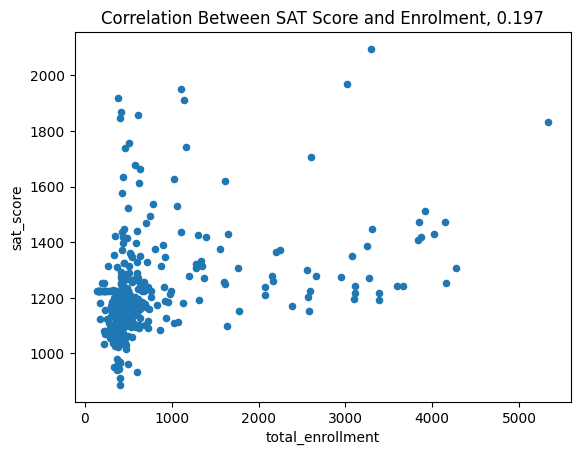

In [84]:
combined.plot.scatter(x="total_enrollment", y="sat_score") # using the pandas.DataFrame.plot() accessor on the dataframe
plt.title(f"Correlation Between SAT Score and Enrolment, {low_enrollment.corr(numeric_only=True)['sat_score']['total_enrollment']:.3f}") # giving a title to the plot
plt.show()

It doesn't look like there's a strong correlation between `sat_score` and `total_enrollment`. However, there is an interesting cluster where both `sat_score` and `total_enrollment` are low. This might be what is making the r value so high. It's worth extracting the names of the schools in this cluster so that we can investigate them more. 

In [72]:
low_enrollment = combined[combined['total_enrollment'] < 1000] # Filtering the dataframe to keep only relevant rows 


# low_enrollment = low_enrollment[low_enrollment['sat_score'] < 1000] # Displaying all of the items in the School Name column of low_enrollment 
# low_enrollment['schoolname']

In [75]:
low_enrollment.corr(numeric_only=True)['sat_score']['total_enrollment']

0.19677223210673825

The correlation between SAT scores and enrollment is quite low.

### Plotting Language Learning Percentage

It is believed that most of the high schools with low total enrollment and low SAT scores have high percentages of English language learners. This shows that it is actually `ell_percent` that is strongly correlated to `sat_score`, not `total_enrollment`. Let's plot out these two values to explore this relationship further.

In [79]:
# Finding correlation between SAT scores and english language learners percentage
correlations['ell_percent']

-0.39874973220852017

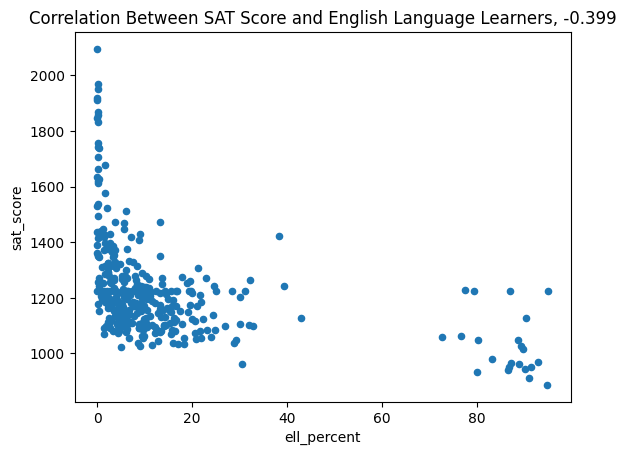

In [85]:
import matplotlib.pyplot as plt
combined.plot.scatter(x="ell_percent", y="sat_score")
plt.title(f"Correlation Between SAT Score and English Language Learners, {correlations['ell_percent']:.3f}") # giving a title to the plot
plt.show()

### Calculating District-Level Statistics

Looking at the school-by-school variation makes it harder to analyse our data. One way to make it easier to read is to aggregate the data by district. 

In [86]:
import numpy

# Aggregating data to better understand how 'ell_percent' varies district-by-district
districts = combined.groupby('school_dist').mean(numeric_only=True) # Grouping 'combined' by 'school_dist' and calculating the average of each group
districts.reset_index(inplace=True) # Resetting the index 

districts.head()

,school_dist,sat critical reading avg. score,sat math avg. score,sat writing avg. score,sat_score,ap test takers,total exams taken,number of exams with scores 3 4 or 5,total cohort,total grads - % of cohort,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,latitude,longitude
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,71.333333,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,75.453574,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,74.029937,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,76.257143,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,75.200881,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


# Analysing the Data 

Now we have all the tools to analyse our data in greater depth. Let's start by plotting the correlation between survey fields and SAT scores.

## Plotting survey correlations

In [91]:
survey_fields

['rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_11',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

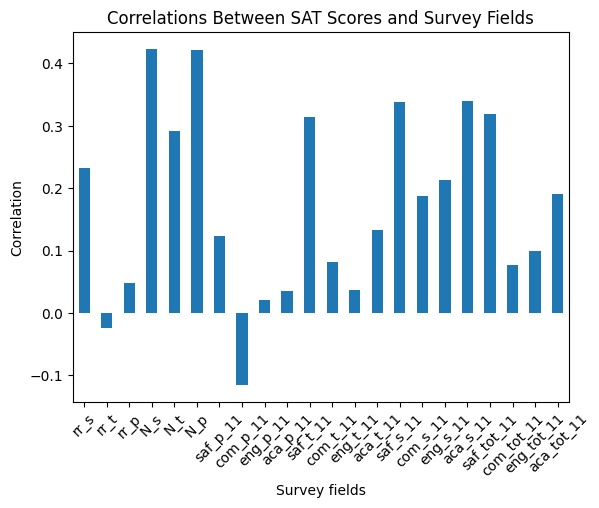

In [96]:
%matplotlib inline

# Removing dbn
# survey_fields.remove("dbn")

# Plotting correlations 
correlations[survey_fields].plot.bar(title="Correlations Between SAT Scores and Survey Fields", rot=45) 
plt.ylabel('Correlation')
plt.xlabel('Survey fields') 
plt.show()

We can make some observations: 

- There is a strong positive correlation between `N_s`, `N_t`, `N_p` and `sat_score`. This might mean that the more the respondents, the more likely students will score high on the SAT test.

- The highest negative correlation is between `comp_p_11` and `sat_score`. This could mean that the less communication there is in the school, the lower the sat scores.
 
- There is a strong correlation between `saf_p_10` and `saf_t_10` and `sat_score`. The safer the environment at school is, the more likely students will be performing well. 
 
- There is a strong correlation between `aca_s_11` and `sat_score`. The way the student perceives the academic standards might have an impact on their test. Yet, this is not true for teachers nor parents' expectations. These scored low in correlation with `sat_score`.
 
- There is not a strong correlation between `eng_t_11` and `eng_p_11` and the `sat_score`. The less engaged teachers and parents are, the less likely students will score high in their test. But, there is a strong correlation between `eng_s_11` and the `sat_score`. This  means that more engaged students  will be more likely to score high.

## Exploring Safety and SAT Scores 

We discovered a strong correlation between how teachers perceive safety and SAT scores. Let's dig into this relationship a bit further to find out which schools have low safety scores.

In [98]:
correlations['saf_s_11']

0.33763874436088115

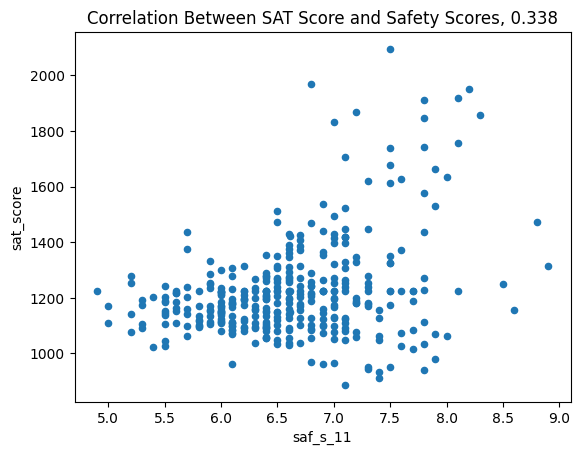

In [100]:
import matplotlib.pyplot as plt

# Creating a scatter plot with the values 
combined.plot.scatter(x='saf_s_11', y='sat_score')
plt.title(f"Correlation Between SAT Score and Safety Scores, {correlations['saf_s_11']:.3f}") 

plt.show()

Judging from the plot above, there is not a strong correlation. There's a large cluster of schools and a few others going off in three different directions. It looks like there are a few schools with high SAT scores and high safety scores. There are a few schools with low SAT scores and low safety scores. Finally, no 
school with safety scores lower than `6.5` has an average SAT score higher than `1500`.

Let's now calculate the average safety score for each borough to discover which borough has the lowest safety score in high schools.

### Borough Safety

In [101]:
# Computing average safety score for each borough 
boros = combined.groupby('boro').mean(numeric_only=True)['saf_s_11']
print(boros)

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


Although there isn't much difference among the scores, it looks like Manhattan and Queens have the highest one, whereas Brooklyn has the lowest.

## Exploring Race and SAT Scores

Let's now explore the correlation between each race and the SAT scores to see if there are racial differences in SAT performance.

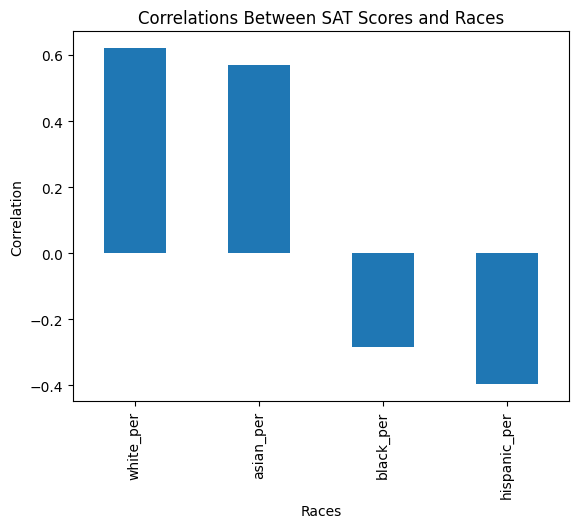

In [57]:
# Listing race fields 
race_fields = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

# Making a bar plot of the correlations between race fields and SAT scores 
combined.corr(numeric_only=True)["sat_score"][race_fields].plot.bar(title="Correlations Between SAT Scores and Races") # giving a title to the plot
plt.ylabel('Correlation') # labelling the axis 
plt.xlabel('Races') 
plt.show()

There is a strong correlation between `sat_score` and white and asian races. This might mean that the SAT test is easier for these people to complete. Yet, there is a strong negative correlation between `sat_score` and `black_per` and `hispanic_per`. Let's explore schools with low SAT scores and high values for `hispanic_per`.

### Exploring Hispanic Demographics and SAT Scores

Text(0.5, 1.0, 'Correlation Between SAT Score and Hispanic Race, -0.397')

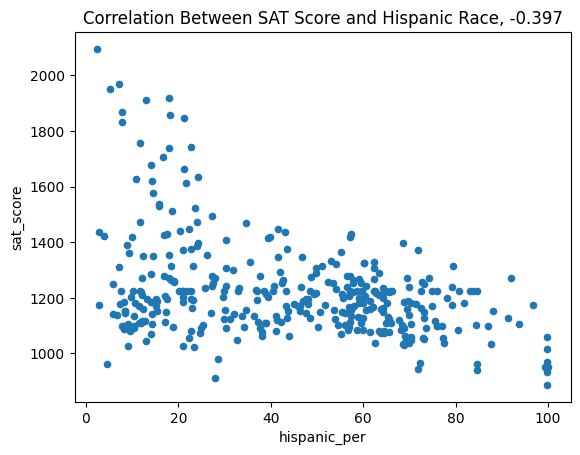

In [105]:
combined.plot.scatter(x='hispanic_per', y='sat_score')
plt.title(f"Correlation Between SAT Score and Hispanic Race, {correlations['hispanic_per']:.3f}")

It looks like there is no strong correlation between `hispanic_per` and `sat_score`. There are a few schools where there is a low percentage of hispanic students and a high SAT score. Other few schools show a high amount of hispanic students and a low SAT score. There is also a cluster where the percentage of hispanic students is around `60` and the SAT score is around `1200`. Let's now research that cluster with a `hispanic_per` greater than `95%`. 

In [112]:
# Finding the school names in the data
combined[combined['hispanic_per'] > 95]['schoolname']

44             Manhattan Bridges High School
82                                         0
89            GREGORIO LUPERON HS SCI & MATH
125      Academy for Language and Technology
141    International School for Liberal Arts
176                                        0
253                Multicultural High School
286                                        0
Name: schoolname, dtype: object

The schools listed serve students who migrated to the U.S.. In these schools, students are learning English, which might explain why they scored low on their SAT tests.

In [106]:
# Researching schools with `hispanic_per` less than 10% and an avg SAT score greater than `1800`
combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]['schoolname']

37                           STUYVESANT HS
151                    BRONX HS OF SCIENCE
187                  BROOKLYN TECHNICAL HS
327    Queens HS for Science York Colllege
356             STATEN ISLAND TECHNICAL HS
Name: schoolname, dtype: object

These schools are specialised in science and technology. They receive extra fundings and only accept students who pass an entrance exam. Although this does not explain the low percentage of hispanic students, it says why their students tend to do better on the SAT exam. 

## Exploring Gender and SAT Scores

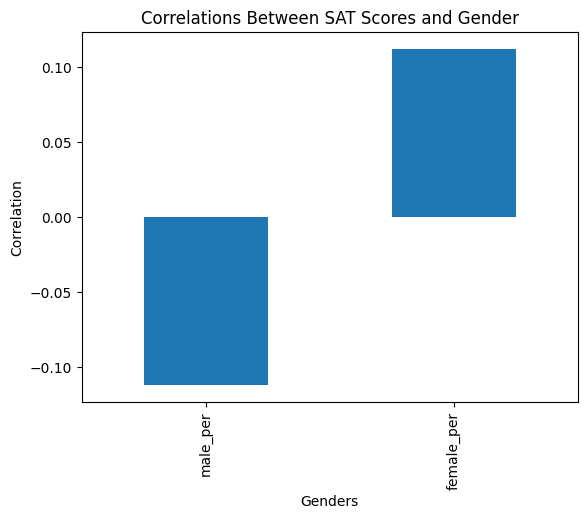

In [115]:
# Listing gender fields 
gender_fields = ['male_per', 'female_per']

combined.corr(numeric_only=True)["sat_score"][gender_fields].plot.bar(title="Correlations Between SAT Scores and Gender") 
plt.ylabel('Correlation') 
plt.xlabel('Genders') 
plt.show()

There is a positive correlation between `female_per` and `sat_score` and a negative one between `male_per` and `sat_scores`. Let's check the scatter plot below to make sure that this bar chart above gives us useful information.

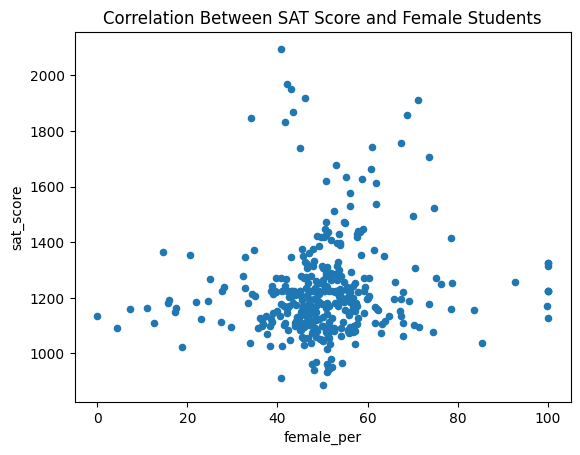

In [118]:
combined.plot.scatter(x='female_per', y='sat_score')
plt.title("Correlation Between SAT Score and Female Students") 
plt.show()

As imagined, we did not find a correlation between schools with high percentage of female students and SAT scores. In fact, there are very few schools where there is a high percentage of female students and a low SAT score. There are also very few schools which have a medium amount of female students with very high scores.

Moreover, we found an interesting cluster where the majority of the schools have from `40%` to `60%` of female students who have a SAT score average of approximately `1200`.

In [120]:
# Finding school names in the data
combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['schoolname']

5                                  0
26     Eleanor Roosevelt High School
60                     BEACON SCHOOL
61           FIORELLO H.LAGUARDIA HS
302               TOWNSEND HARRIS HS
Name: schoolname, dtype: object

It looks like these school are very selective liberal art schools which have high academic standards.

## Exploring AP Scores vs. SAT Scores

Let's now look at the percentage of students in each school who took at least one AP exam. Will we find a correlation with the SAT scores?

In [121]:
# Dividing the number of students who took the AP test by the `total_enrollment` column
combined['ap_per'] = (combined['ap test takers '] / combined['total_enrollment']) # Adding an extra space at the end of the `AP Test Takers ` column
print(combined['ap_per'])

0      0.305756
1      0.098985
2      0.031773
3      0.351577
4      0.158091
         ...   
358    0.077558
359    0.297301
360    0.190955
361    0.026616
362    0.073593
Name: ap_per, Length: 363, dtype: float64


/var/folders/qs/fdrj_gks73v_3fn5zbpyl2000000gn/T/ipykernel_65207/2175981502.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined['ap_per'] = (combined['ap test takers '] / combined['total_enrollment']) # Adding an extra space at the end of the `AP Test Takers ` column


Text(0.5, 1.0, 'Correlation Between SAT Score and AP Score')

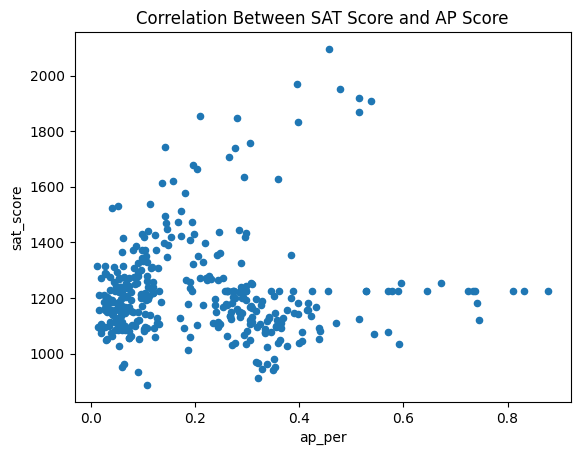

In [122]:
# Investigating the relationship between AP scores and SAT scores
combined.plot.scatter(x='ap_per', y='sat_score')
plt.title("Correlation Between SAT Score and AP Score") 

There is a weak correlation between students who took the AP test and the SAT score.

# Conclusions

In this project, we've explored the relationship between SAT scores and demographic factors in New York City (NYC) public high schools. Since New York City has a very diverse population, comparing multiple demographics such as race, income, and gender is a good way to check whether the SAT test is fair or not. We've performed our analysis by combining multiple datasets into a single, clean pandas dataframe. We then started analysing the data by creating correlations and plotting them. We eventually found out that:

- Safety scores by students and teachers are indicators of high SAT scores.
- White/ asian races could indicate high SAT scores, whereas black/ hispanic would indicate low SAT scores. 
- Gender is not a very strong indicator of high SAT scores.
- There are exceptions to the races and gender indicators. However, these are schools with high technical funding and standardised admission criterias. 

Despite our final conclusions, there's still quite a bit of analysis to do. For instance, we could try to determine whether there's a correlation between class size of SAT scores. Another question could be: "Which neighborhood has the best school?": we could try to answer this question by combining our current dataset with one that contains property values. In that way, we could find the least expensive neighborhoods that have good schools. Finally, it'd be interesting to investigate the differences between parents, teachers, and students responses to surveys. 